<img src="https://raw.githubusercontent.com/UCLAMAEThreads/FluidDynTools.jl/main/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **Introduction to Fluid Dynamics**
<hr />

# Flow lines and the material derivative in a steady flow field
In this notebook we will discuss:
* Path lines (particle trajectories)
* The material derivative
* Streamlines and the streamfunction

and observe them in a pre-computed steady flow field.

### Set up the module

In [1]:
using FluidDynTools

In [2]:
using Plots

### Load the flow from file
First, let us load the flow from a pre-computed CFD solution. This is the **steady state**
flow past a NACA 4415 airfoil at 5 degrees angle of attack at Reynolds number 500.

In the command below, `u` contains the solution field, `t` the time (which is not that
important in this problem, since it is steady), and `sys` contains some operators for quickly
getting other information about the flow. It takes a few seconds for this to do its work,
so be patient:

In [3]:
filename = "NACA4415Re500.jld2"
u, t, sys = load_ns_solution(filename);

For our immediate use, let's get the velocity field (`ufield`, `vfield`) for this flow. We get that with
the `velocity_xu` function in the `ViscousFlow` package. This velocity field will serve a lot of our discussion below.

In [4]:
ufield, vfield = ViscousFlow.velocity_xy(u,sys,t);

## Particle trajectories (i.e., pathlines)
First, let us discuss particle trajectories.

A particle moves at a velocity $\mathbf{V}(t)$ equal to the fluid velocity field,
$\mathbf{u}(\mathbf{x},t)$, evaluated at the particle's location $\mathbf{r}(t)$.
We can write this mathematically as

$$\mathbf{V}(t) = \mathbf{u}(\mathbf{r}(t),t)$$

This means that the particle's trajectory, $\mathbf{r}(t)$, is determined by the equation

$$ \dfrac{\mathrm{d}\mathbf{r}}{\mathrm{d}t} = \mathbf{u}(\mathbf{r}(t),t) $$

If we integrate this equation over time, starting from some initial location $\mathbf{r}(0)$,
then we get the trajectory of a single fluid particle.

If the velocity field is **steady**, then this equation simplifies a bit, because we lose the
second argument ($t$) of $\mathbf{u}$, and we thus have only one unchanging velocity field to
integrate.

If we want to look at trajectories of many particles, then we simply integrate this equation for each particle.
Each particle corresponds to a different initial condition.

 Let's compute the trajectories, $\mathbf{r}_p(t)$, of a few particles $p = 1,\ldots,n$, in
 this steady velocity field. We will release them from some places upstream of the airfoil and
 see where they go over a time interval.

Initial locations of the particles. Each pair is the initial coordinates of a particle. You can (and should) play
around with these, add more particles, etc.

In [5]:
pts = [ [-1,0.25], [-1,0.015], [-1,-0.015], [-1,-0.03], [-1,-0.25],[-1,-0.5],  [-1,-0.75] ];

Time range over which to compute the trajectory (from t = 0 to t = Tmax). You might need to change this to
make the trajectories go far enough.

In [6]:
Trange = (0.0,25.0);

Compute the trajectories.

In [7]:
traj = compute_trajectory(ufield,vfield,pts,Trange);

Each entry in the output array `traj` contains a trajectory of a particle. For example,
`traj[1]` contains the trajectory of particle 1, $\mathbf{r}_1(t)$.

Plot the trajectory, $\mathbf{r}_p(t)$, of each particle

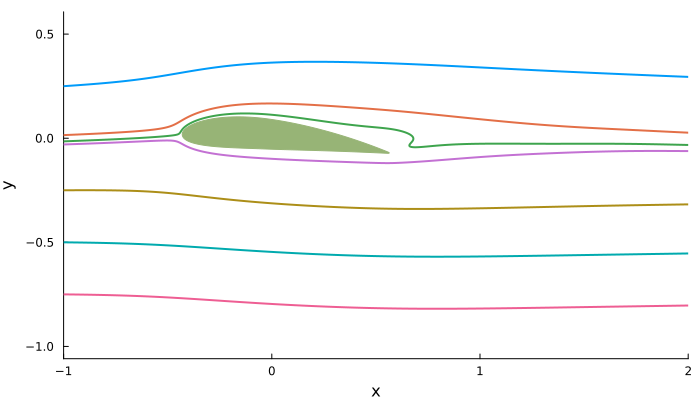

In [8]:
plot(traj,xlim=(-1,2))
plot!(surfaces(sys))

## Particle acceleration and the material derivative of velocity
Now, let's develop some intuition for how the particle's velocity changes along its
trajectory---i.e., the acceleration. From the particle's perspective (the Lagrangian perspective),
this is simply

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} $$

But earlier, we equated the particle's velocity to the local fluid velocity field. If we take the
time derivative of both sides of this equation, then, by the chain rule, we get

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} = \dfrac{\mathrm{d}\mathbf{r}}{\mathrm{d}t} \cdot \nabla \mathbf{u}(\mathbf{r}(t),t) + \dfrac{\partial \mathbf{u}}{\partial t} (\mathbf{r}(t),t).$$

Notice the appearance of the particle velocity ($\mathrm{d}\mathbf{r}/\mathrm{d}t$) on the
right-hand side. We can replace this with the local fluid velocity. Let's also switch the order
of the terms, as is conventional:

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} = \dfrac{\partial \mathbf{u}}{\partial t}(\mathbf{r}(t),t) + \mathbf{u} \cdot \nabla \mathbf{u}(\mathbf{r}(t),t).$$

The right hand side is called the material derivative of velocity, $D\mathbf{u}/Dt$. It contains
two terms: a **convective acceleration** ($\mathbf{u}\cdot\nabla\mathbf{u}$), due to spatial changes of velocity along the particle's path, and an **unsteady term** ($\partial\mathbf{u}/\partial t$), due to time changes in the velocity field itself.

Like the fluid velocity, it is a field quantity (a function of space and time, independently of
each other). Here, it is evaluated at the location of the particle:

$$ \dfrac{\mathrm{d}\mathbf{V}}{\mathrm{d}t} = \dfrac{D \mathbf{u}}{D t} (\mathbf{r}(t),t)$$

### Material derivative in action
Let's explore this equality on our steady airfoil flow. In such a flow, the material
derivative just contains the convective acceleration:

$$ \dfrac{D \mathbf{u}}{D t} = \mathbf{u}\cdot\nabla\mathbf{u}$$

So if we compute the convective acceleration field and then evaluate it along the particle's
trajectory, this should be equal to the particle's acceleration. Let's try this.

#### Velocity along the trajectory
First, let us calculate the velocity along one of the particle trajectories:

In [9]:
particle_number = 2

2

Plot the velocity components as a function of the $x$ component of the trajectory.
This allows us to see how these components change as the particle encounters the airfoil.
We also plot the particle's trajectory for reference.

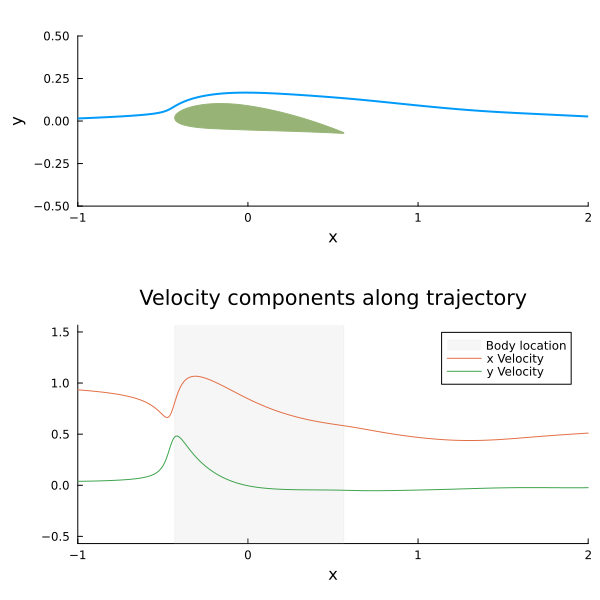

In [10]:
fieldtrajectory(traj,(ufield, vfield),sys,particle_number,fieldlabel="Velocity",xlim=(-1,2))

Notice how the particle's u component drops as it encounters the nose of the airfoil, while
the v component gets larger as the particle moves toward the top of the airfoil.

The u component then **accelerates rapidly**---to a value even larger than the background flow
speed---as it passes over the upper surface. (By the way: this aspect is essential for generating lift.)

Then both components get smaller as the particle passes over the rear part of the wing.

#### Plotting other quantities along the trajectory
Let's look at another important quantity along the trajectory: the pressure.

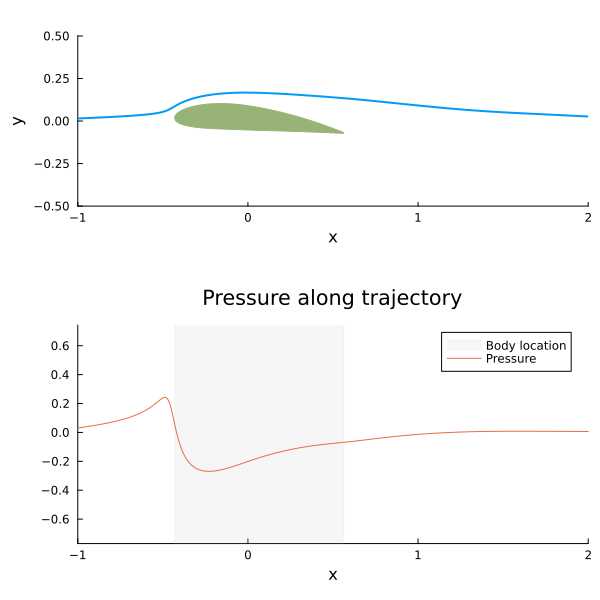

In [11]:
press = ViscousFlow.pressure_xy(u,sys,t)
fieldtrajectory(traj,press,sys,particle_number,fieldlabel="Pressure",xlim=(-1,2))

Note that pressure rises dramatically as the particle gets close to the nose of the airfoil.
It is nearly achieving its stagnation value there. Then, as the particle passes over the upper
surface, it becomes negative. This is the suction experienced on the upper side of the wing, necessary for
achieving lift. Eventually, the pressure relaxes back to zero in the wake of the wing.

#### Rate of change of particle velocity
Let's evaluate the rate of change of this particle velocity. We do this by
taking the time derivative of the velocity along the particle's path. The `fieldtrajectory`
plotting function enables this with an extra argument `deriv=1`:

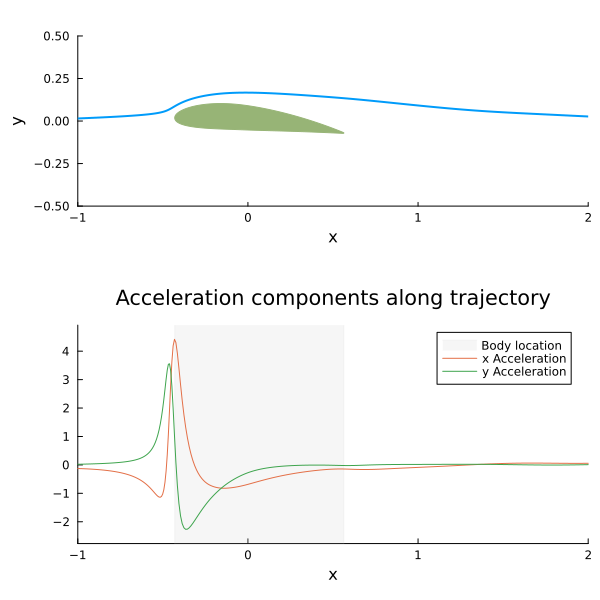

In [12]:
fieldtrajectory(traj,(ufield,vfield),sys,particle_number,fieldlabel="Acceleration",deriv=1,xlim=(-1,2))

Now let's compute the convective acceleration field, $\mathbf{u}\cdot\nabla\mathbf{u}$,
and evaluate it along the particle's trajectory.

In [13]:
ugradu = ViscousFlow.convective_acceleration_xy(u,sys,t);

Plot the acceleration components. We will compare the particle's acceleration,
$\mathrm{d}\mathbf{V}/\mathrm{d}t$, to the convective acceleration evaluated along
the trajectory, $\mathbf{u}\cdot\nabla\mathbf{u}(\mathbf{r}(t))$. They should be equal:

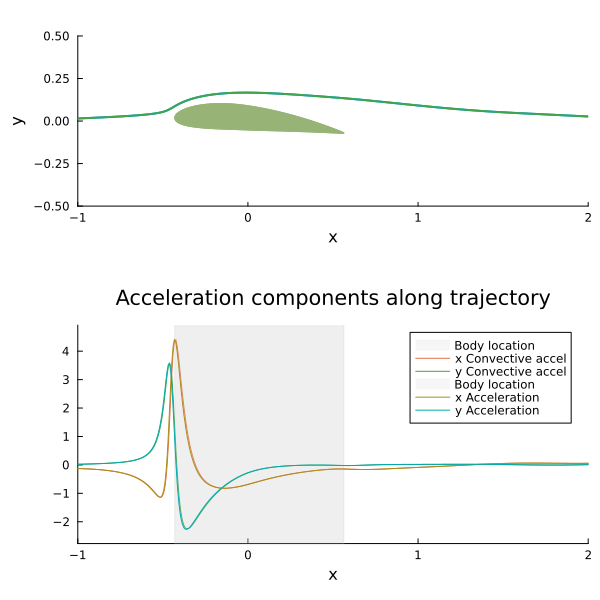

In [14]:
fieldtrajectory(traj,ugradu,sys,particle_number,fieldlabel="Convective accel",xlim=(-1,2))
fieldtrajectory!(traj,(ufield,vfield),sys,particle_number,fieldlabel="Acceleration",deriv=1)

The two sets of components lie right on top of each other. In other words, they are identical!

This confirms that these two ways of viewing the acceleration---the Lagrangian view from the
particle's perspective, and the Eulerian calculation of an acceleration field (the convective
derivative)---are, indeed, the same. (If this were an unsteady field, we would need to also
account for the unsteady part of the acceleration.)

## Streamlines and the streamfunction
Streamfunction, $\psi$, is another important quantity in fluid dynamics, and we will
return to this later. What is its value along the particle trajectory? Let's find out:

In [15]:
ψ = ViscousFlow.streamfunction_xy(u,sys,t);

Plot the streamfunction as a function of $x$ along trajectory:

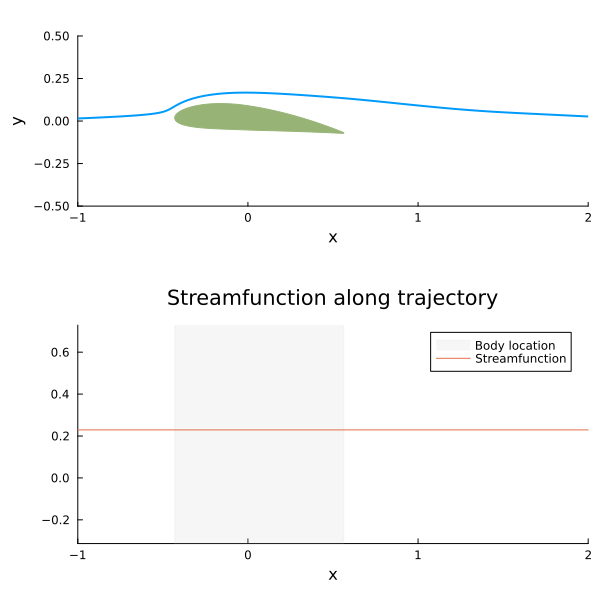

In [16]:
fieldtrajectory(traj,ψ,sys,particle_number,fieldlabel="Streamfunction",xlim=(-1,2))

It's constant! Why? Because **streamfunction is constant along streamlines**, and in steady flow,
the **particle pathlines are identical to streamlines**.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*